In [1]:
import numpy as np
import copy
from tqdm import tqdm

# Start of the debugging

In [2]:
# Definir vr y vx
vr = np.array([0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

vx = np.array([-3.5, -3.39525444373403, -3.291393274968879, -3.1884164937045467, 
               -3.086324099941034, -2.9851160936783403, -2.8847924749164653, 
               -2.785353243655409, -2.6867983998951717, -2.5891279436357535, 
               -2.4923418748771544, -2.396440193619374, -2.301422899862413, 
               -2.207289993606271, -2.1140414748509473, -2.0216773435964432, 
               -1.9301975998427576, -1.8396022435898913, -1.749891274837844, 
               -1.6610646935866153, -1.5731224998362061, -1.4860646935866155, 
               -1.3998912748378438, -1.3146022435898914, -1.230197599842758, 
               -1.146677343596443, -1.0640414748509475, -0.9822899936062708, 
               -0.901422899862413, -0.8214401936193743, -0.7423418748771545, 
               -0.6641279436357537, -0.5867983998951719, -0.510353243655409, 
               -0.43479247491646505, -0.3601160936783402, -0.2863240999410342, 
               -0.21341649370454718, -0.14139327496887916, -0.07025444373403009, 
               0.07025444373403009, 0.14139327496887916, 0.21341649370454718, 
               0.2863240999410342, 0.3601160936783402, 0.43479247491646505, 
               0.510353243655409, 0.5867983998951719, 0.6641279436357537, 
               0.7423418748771545, 0.8214401936193743, 0.901422899862413, 
               0.9822899936062708, 1.0640414748509475, 1.146677343596443, 
               1.230197599842758, 1.3146022435898914, 1.3998912748378438, 
               1.4860646935866155, 1.5731224998362061, 1.6610646935866153, 
               1.749891274837844, 1.8396022435898913, 1.9301975998427576, 
               2.0216773435964432, 2.1140414748509473, 2.207289993606271, 
               2.301422899862413, 2.396440193619374, 2.4923418748771544, 
               2.5891279436357535, 2.6867983998951717, 2.785353243655409, 
               2.8847924749164653, 2.9851160936783403, 3.086324099941034, 
               3.1884164937045467, 3.291393274968879, 3.39525444373403, 3.5])

# IDL> help, vol 
# VOL             DOUBLE    = Array[40, 80]


print(vr.shape)

(40,)


In [3]:
''' 
Version 01
Authors: Julio Balbin, Carlo Becerra
Date: August 17th, 2024
'''
def Make_dVr_dVx(vr: np.ndarray
                ,vx: np.ndarray):
    ''' 
    vr & vx are from:
    -> 1090904024_950to1050.sav

    Constructs velocity space differentials for distribution functions
    used by Kinetic_Neutrals.pro, Kinetic_H2.pro, Kinetic_H2.pro

    The abs(difference) between vol variable in python & IDL is in the range: 
    <(np.float64(1.433306555442826e-06), np.float64(6.70904781382986e-12)>
    '''

    # nvr & nvx are taking the shape of vr & vx respectively
    nvr = vr.size
    nvx = vx.size

    # Calculations for r-dimension
    _vr     = np.append(vr, 2 * vr[-1] - vr[-2])
    vr_mid  = np.concatenate(([0.0], 0.5 * (_vr + np.roll(_vr, -1))))

    vrR = np.roll(vr_mid, -1)[0:nvr]
    vrL = copy.copy(vr_mid)[0:nvr]

    Vr2pidVr    =         np.pi * (vrR**2 - vrL**2)
    VrVr4pidVr  = (4/3) * np.pi * (vrR**3 - vrL**3)

    # Calculations for x-dimension
    _vx = np.concatenate(([2 * vx[0] - vx[1]], vx, [2 * vx[-1] - vx[-2]]))

    vxR = 0.5 * (np.roll(_vx, -1) + _vx)[1:nvx+1]
    vxL = 0.5 * (np.roll(_vx,  1) + _vx)[1:nvx+1]

    dVx = vxR - vxL

    # Calc. volumen
    vol = np.zeros((nvr, nvx), dtype=np.float64)
    for i in tqdm(range(nvr), desc=f"Make_dVr_dVx: calc. vol"): 
        vol[i, :] = Vr2pidVr[i] * dVx
        
    Deltavx = vxR - vxL
    Deltavr = vrR - vrL

    vth_Deltavx =np.zeros((nvr+2,nvx+2))
    vx_Deltavx  =np.zeros((nvr+2,nvx+2))
    vr_Deltavr  =np.zeros((nvr+2,nvx+2))

    for j in tqdm(range(1,nvr+1),desc=f"Make_dVr_dVx: calc. vth & vx"):
        vth_Deltavx[j,1:nvx+1] = 1.0/Deltavx    # vth_Deltavx(i,1:nvx)=1.0/Deltavx
        vx_Deltavx[ j,1:nvx+1] =  vx/Deltavx     #  vx_Deltavx(i,1:nvx)= vx/Deltavx

    for k in tqdm(range(1,nvx+1),desc=f"Make_dVr_dVx: calc. vr"):
        vr_Deltavr[ 1:nvr+1,k] =  vr/Deltavr     #  vr_Deltavr(1:nvr,j)=vr/Deltavr
    
    # Compute v^2
    vr2vx2=np.zeros((nvr,nvx), dtype=np.float64)
    for l in range(0,nvr):
        vr2vx2[l,:] = vr[l]**2 + vx**2

    # vx's positive index
    jp = copy.copy(np.where(vx>0)[0])   # This saves the positives index of vx
    jpa = int(jp[0])                    # This saves the first index of jp
    jpb = int(jp[len(jp)-1])            # This saves the last index of jp

    # vx's negative index   
    jn = copy.copy(np.where(vx<0)[0])   # This saves the negatives index of vx
    jna = int(jn[0])                    # This saves the first index of jp
    jnb = int(jn[len(jn)-1])            # This saves the last index of jp

    return Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
           vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
           jpa,jpb,jna,jnb


Vr2pidVr, VrVr4pidVr,dVx,vrL,vrR,vxL,vxR,\
           vol,vth_Deltavx,vx_Deltavx,vr_Deltavr,vr2vx2,\
           jpa,jpb,jna,jnb = Make_dVr_dVx(vr,vx)



Make_dVr_dVx: calc. vr: 100%|██████████| 80/80 [00:00<00:00, 79929.57it/s]


In [4]:
# Import values from IDL version
# Only for validation purpouses
# we're looking for the min & max errors
vol_sp = np.loadtxt('vol.txt')
vol_sp = vol_sp.reshape((40,80))
vol_db = np.loadtxt('draft_Make_dVr_dVx_vol.dat')
vol_db = vol_db.reshape((40,80))
vol_db

array([[0.00368514, 0.00366957, 0.00363845, ..., 0.00363845, 0.00366957,
        0.00368514],
       [0.00667148, 0.00664329, 0.00658696, ..., 0.00658696, 0.00664329,
        0.00667148],
       [0.01018885, 0.01014581, 0.01005977, ..., 0.01005977, 0.01014581,
        0.01018885],
       ...,
       [0.22403994, 0.22309346, 0.22120155, ..., 0.22120155, 0.22309346,
        0.22403994],
       [0.23308562, 0.23210093, 0.23013262, ..., 0.23013262, 0.23210093,
        0.23308562],
       [0.24128021, 0.24026091, 0.23822342, ..., 0.23822342, 0.24026091,
        0.24128021]])

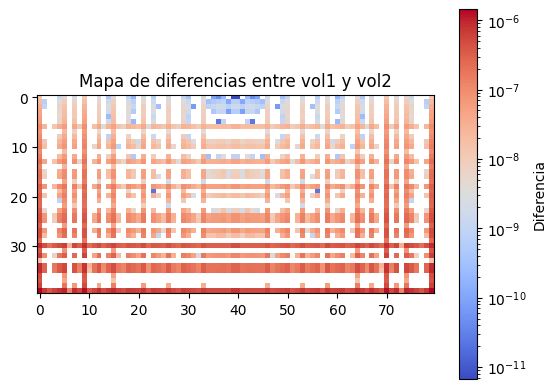

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mplc

diferencia = vol_db -vol
diferencia_absoluta = np.abs(diferencia)

# plt.imshow(diferencia, cmap='coolwarm', interpolation='nearest')
# plt.colorbar(label='Diferencia')
my_cmap = plt.cm.coolwarm
plt.imshow(diferencia, cmap=my_cmap, interpolation='nearest',norm=mplc.LogNorm())
plt.colorbar(label='Diferencia')
plt.title("Mapa de diferencias entre vol1 y vol2")

plt.show()


In [6]:
diferencia_absoluta.max(),diferencia_absoluta.min()

(np.float64(1.433306555442826e-06), np.float64(6.70904781382986e-12))